### References

- https://adversarial-ml-tutorial.org/adversarial_examples/
- https://arxiv.org/pdf/1905.02175.pdf

In [2]:
import tensorflow as tf
from tensorflow import keras as K
import tensorflow_datasets as tfds

import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import pandas as pd
import time

In [3]:
def normalize(img, label):
    return img / 255, label

def make_tf_data(raw_ds):
    ds = raw_ds.map(normalize)
    return ds

In [4]:
def build_cnn_model(n_layers, n_filters, kernel_size=3, n_classes=10, model_name='basic_cnn'):
    """Builds basic CNN model for adversarial training; will need to be refactored
    non-using default train setup"""
    input_layer = tf.keras.layers.Input(shape=(28,28,1))
    
    # Add basic convolutional_layer
    hidden = tf.keras.layers.Conv2D(n_filters, kernel_size=3, strides=2, activation = 'relu')(input_layer)
    # Add single dense, non-linear layer
    hidden = tf.keras.layers.Flatten()(hidden)
    hidden = tf.keras.layers.Dense(16, activation = 'relu')(hidden)
    output = tf.keras.layers.Dense(n_classes, activation='softmax')(hidden) # softmax since multiclass class. problem
    
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    return model

In [ ]:
cifar_train = tfds.load('cifar10', split='train', shuffle_files=True, as_supervised=True, batch_size=32)
cifar_test = tfds.load('cifar10', split='test', shuffle_files=True, as_supervised=True, batch_size=32)

cifar_train = make_tf_data(cifar_train)
cifar_test = make_tf_data(cifar_)

In [5]:
train_ds = tfds.load('mnist', split='train', shuffle_files=True, as_supervised=True, batch_size=32)
test_ds = tfds.load('mnist', split='test', shuffle_files=True, as_supervised=True, batch_size=32)

train_ds = make_tf_data(train_ds)
test_ds = make_tf_data(test_ds)

2021-11-16 19:45:49.079165: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-16 19:45:49.107949: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa187786e20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-11-16 19:45:49.107968: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


### Train robust model resistant to FGSM attacks

In [6]:
@tf.function
def fgsm_attack(model, X, y, epsilon=0.1):
    delta = tf.zeros_like(X)
    
    # use GradientTape to perform autodiff
    with tf.GradientTape() as tape:
        # specifically 'watch' delta
        # see here: https://www.tensorflow.org/guide/autodiff
        tape.watch(delta)
        loss = tf.keras.losses.SparseCategoricalCrossentropy()(y, model(X + delta))
    delta = tf.sign(tape.gradient(loss, delta)) * epsilon
    return delta

In [35]:
@tf.function
def onestep_pgd_linf(model, X, y, epsilon, alpha, delta):
    with tf.GradientTape() as tape:
        tape.watch(delta)
        loss = tf.keras.losses.SparseCategoricalCrossentropy()(y, model(X + delta))

    delta = tf.clip_by_value(delta + alpha*tf.sign(tape.gradient(loss, delta)), -epsilon, epsilon)
    
    return delta

def pgd_linf(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = tf.zeros_like(X)
    for t in range(num_iter):
        delta = onestep_pgd_linf(model, X, y, epsilon, alpha, delta)
    return delta

In [37]:
EPOCHS = 5

# Build model again, leaving out summary
robust_model = build_cnn_model(1, 32)

robust_model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

for n in range(EPOCHS):
    t = time.time()
    train_losses = []
    train_accs = []
    for b in train_ds:
        X, y = b
        
        # Apply attack during training as well as testing
        delta = fgsm_attack(robust_model, X, y, 0.02)
#         delta = pgd_linf(robust_model, X, y, epsilon=0.1, alpha=1e-2, num_iter=40)
        Xd = X + delta

        l, acc = robust_model.train_on_batch(Xd, y)
        train_losses.append(l)
        train_accs.append(acc)

    test_losses = []
    test_accs = []
    for vb in test_ds:
        Xtest, ytest = vb
        
        # Apply attack to get delta
        # Importantly, only attack at test time rather than during training
        #delta = fgsm_attack(model, Xtest, ytest)
        Xdtest = Xtest #+ delta
        
        l, acc = robust_model.test_on_batch(Xdtest, ytest)
        test_losses.append(l)
        test_accs.append(acc)
    
    train_loss = sum(train_losses) / len(train_losses)
    train_acc = sum(train_accs) / len(train_accs)
    
    test_loss = sum(test_losses) / len(test_losses)
    test_acc = sum(test_accs) / len(test_accs)
        
    print(f"Epoch {n}/{EPOCHS}, Time: {(time.time()-t):0.2f} -- Train Loss: {train_loss:0.2f}, \
Train Acc: {train_acc:0.2f}, Test Loss: {test_loss:0.2f}, Test Acc: {test_acc:0.2f}")

Epoch 0/5, Time: 14.32 -- Train Loss: 0.37, Train Acc: 0.89, Test Loss: 0.13, Test Acc: 0.96
Epoch 1/5, Time: 11.62 -- Train Loss: 0.18, Train Acc: 0.95, Test Loss: 0.09, Test Acc: 0.97
Epoch 2/5, Time: 12.63 -- Train Loss: 0.14, Train Acc: 0.96, Test Loss: 0.08, Test Acc: 0.98
Epoch 3/5, Time: 12.40 -- Train Loss: 0.12, Train Acc: 0.96, Test Loss: 0.07, Test Acc: 0.98
Epoch 4/5, Time: 14.22 -- Train Loss: 0.11, Train Acc: 0.97, Test Loss: 0.06, Test Acc: 0.98


### Generate robust version of original data

Use robust NN to create a robustifier

In [38]:
# Grab representation layer from robust model
representation = robust_model.layers[-2]
robustifier = tf.keras.Model(inputs = robust_model.input, outputs = representation.output)

In [39]:
def norm(Z):
    """Compute norms over all but the first dimension"""
    return tf.norm(Z[0,:,:,:])

@tf.function
def single_pgd_step(model, X, y, alpha, delta):
    with tf.GradientTape() as tape:
        tape.watch(delta)
        loss = tf.keras.losses.MeanSquaredError()(y, model(X + delta))

    grad = tape.gradient(loss, delta)
    delta -= alpha*grad / norm(grad) # normalized gradient step
    delta = tf.math.minimum(tf.math.maximum(delta, -X), 1-X) # clip X+delta to [0,1]
    
    return delta, loss

def pgd_l2(model, X, y, alpha, num_iter):
    delta = tf.zeros_like(X)
    loss = 0
    for t in range(num_iter):
        delta, loss = single_pgd_step(model, X, y, alpha, delta)
            # No epsilon bound here
    #         delta.data *= epsilon / norms(delta.detach()).clamp(min=epsilon) 
            # I think tensorflow does this automatically
#             delta.grad.zero_()

    if example:
        print(f'{num_iter} iterations, final MSE {loss}')
    return delta

In [40]:
unbatched_train = train_ds.unbatch()

In [18]:
robust_train = []
orig_labels = []
iters = 100
example = False
start_time = time.time()
for i, (img, label) in enumerate(unbatched_train):
    # data point we want to get robust features for
    curr_img = tf.expand_dims(img, axis=0)
    goal_representation = robustifier(curr_img)
    
    # starting point for PGD is another point in the dataset
    rand_img = next(unbatched_train.shuffle(int(1e6)).take(1).as_numpy_iterator())[0]
    rand_img = tf.expand_dims(rand_img, axis=0)
    
    learned_delta = pgd_l2(robustifier, rand_img, goal_representation, alpha=0.1, num_iter=iters)
    robust_update = (rand_img + learned_delta)[0,:,:,:] # trim off first dim
    robust_train.append(robust_update)
    orig_labels.append(label)
    
    if i%1000 == 0:
        elapsed = time.time() - start_time
        print(f'Robustified {i} images in {elapsed:0.3f} seconds')
        start_time = time.time()

Robustified 0 images in 0.347 seconds
Robustified 1000 images in 270.550 seconds
Robustified 2000 images in 276.991 seconds
Robustified 3000 images in 301.226 seconds
Robustified 4000 images in 293.552 seconds
Robustified 5000 images in 308.053 seconds
Robustified 6000 images in 293.672 seconds
Robustified 7000 images in 285.187 seconds
Robustified 8000 images in 282.198 seconds
Robustified 9000 images in 288.534 seconds
Robustified 10000 images in 275.635 seconds
Robustified 11000 images in 286.838 seconds


KeyboardInterrupt: 

1 iterations, final MSE 25.184667587280273
2 iterations, final MSE 24.665740966796875
50 iterations, final MSE 2.3101258277893066
100 iterations, final MSE 0.014971546828746796
1000 iterations, final MSE 0.014659932814538479


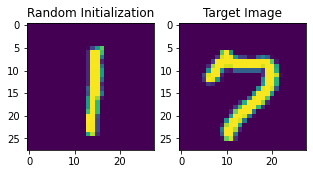

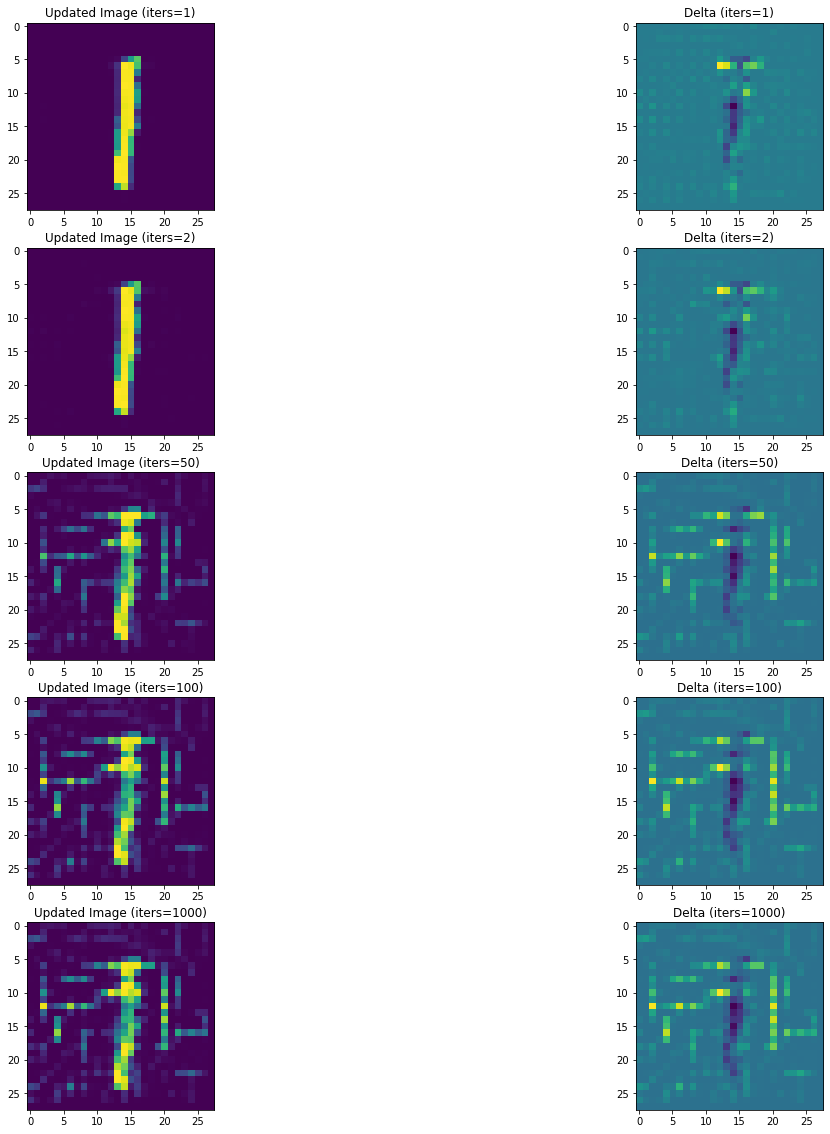

In [41]:
example = True
for img, label in unbatched_train:
    # data point we want to get robust features for
    curr_img = tf.expand_dims(img, axis=0)
    goal_representation = robustifier(curr_img)
    
    # starting point for PGD is another point in the dataset
    rand_img = next(unbatched_train.shuffle(int(1e6)).take(1).as_numpy_iterator())[0]
    rand_img = tf.expand_dims(rand_img, axis=0)
    
    fig, starts = plt.subplots(1,2,figsize=(5,5))
    starts = starts.flatten()
    starts[0].imshow(rand_img[0,:,:,:].numpy())
    starts[0].set_title('Random Initialization')
    starts[1].imshow(curr_img[0,:,:,:])
    starts[1].set_title('Target Image')
    
    fig, axs = plt.subplots(5, 2, figsize=(20,20))
    for i, iters in enumerate([1,2,50,100,1000]):
        learned_delta = pgd_l2(robustifier, rand_img, goal_representation, alpha=0.1, num_iter=iters)
        robust_update = (rand_img + learned_delta)[0,:,:,:] # trim off first dim
    
        axs[i][0].imshow(robust_update)
        axs[i][0].set_title(f'Updated Image (iters={iters})')
        axs[i][1].imshow(learned_delta[0,:,:,:])
        axs[i][1].set_title(f'Delta (iters={iters})')
        
    break

### Try training on robust data set and testing with adversarial examples

In [26]:
orig_labels[-10].numpy()

9

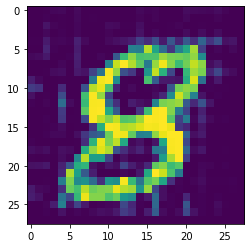

In [27]:
plt.imshow(robust_train[-10].numpy())

In [28]:
robust_ds = tf.data.Dataset.from_tensor_slices((robust_train, orig_labels)).batch(32)

In [29]:
EPOCHS = 5

# Build model again, leaving out summary
model = build_cnn_model(1, 32)

model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

for n in range(EPOCHS):
    
    t = time.time()
    train_losses = []
    train_accs = []
    for b in robust_ds:
        X, y = b

        l, acc = model.train_on_batch(X, y)
        train_losses.append(l)
        train_accs.append(acc)

    test_losses = []
    test_accs = []
    for vb in test_ds:
        Xtest, ytest = vb
        
        # Apply attack to get delta
        # Importantly, only attack at test time rather than during training
        delta = fgsm_attack(model, Xtest, ytest)
        Xdtest = Xtest + delta
        
        l, acc = model.test_on_batch(Xdtest, ytest)
        test_losses.append(l)
        test_accs.append(acc)
    
    train_loss = sum(train_losses) / len(train_losses)
    train_acc = sum(train_accs) / len(train_accs)
    
    test_loss = sum(test_losses) / len(test_losses)
    test_acc = sum(test_accs) / len(test_accs)
        
    print(f"Epoch {n}/{EPOCHS}, Time: {(time.time()-t):0.2f} -- Train Loss: {train_loss:0.2f}, \
Train Acc: {train_acc:0.2f}, Test Loss: {test_loss:0.2f}, Test Acc: {test_acc:0.2f}")

Epoch 0/5, Time: 3.90 -- Train Loss: 1.18, Train Acc: 0.63, Test Loss: 7.34, Test Acc: 0.00
Epoch 1/5, Time: 3.23 -- Train Loss: 0.45, Train Acc: 0.86, Test Loss: 9.27, Test Acc: 0.00
Epoch 2/5, Time: 3.24 -- Train Loss: 0.32, Train Acc: 0.90, Test Loss: 10.31, Test Acc: 0.00
Epoch 3/5, Time: 3.22 -- Train Loss: 0.26, Train Acc: 0.92, Test Loss: 11.20, Test Acc: 0.00
Epoch 4/5, Time: 4.10 -- Train Loss: 0.22, Train Acc: 0.94, Test Loss: 12.32, Test Acc: 0.00
